✅ Total images found: 5722
🧾 Class distribution:
 class
notumor       1595
pituitary     1467
meningioma    1339
glioma        1321
Name: count, dtype: int64
Found 3890 validated image filenames belonging to 4 classes.
Found 687 validated image filenames belonging to 4 classes.
Found 1145 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 131s 555ms/step - accuracy: 0.7778 - loss: 0.5977 - val_accuracy: 0.8952 - val_loss: 0.2492
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 46s 377ms/step - accuracy: 0.9579 - loss: 0.1239 - val_accuracy: 0.8719 - val_loss: 0.4286
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 47s 385ms/step - accuracy: 0.9721 - loss: 0.0833 - val_accuracy: 0.9258 - val_loss: 0.2356
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 47s 383ms/step - accuracy: 0.9747 - loss: 0.0690 - val_accuracy: 0.9185 - val_loss: 0.2666
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 48s 394ms/step - accuracy: 0.9832 - loss: 0.0486 - val_accuracy: 0.9709 - val_loss: 0.0946
Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 47s 387ms/step - accuracy: 0.9811 - loss: 0.0500 - val_accuracy: 0.9738 - val_loss: 0.0927
Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 46s 379ms/step - accuracy: 0.9927 - loss: 0.0228 - val_accuracy: 0.9665 - val_loss: 0.1781
Epoch 8/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 46s 375ms/step - accuracy: 0.9911 - loss: 

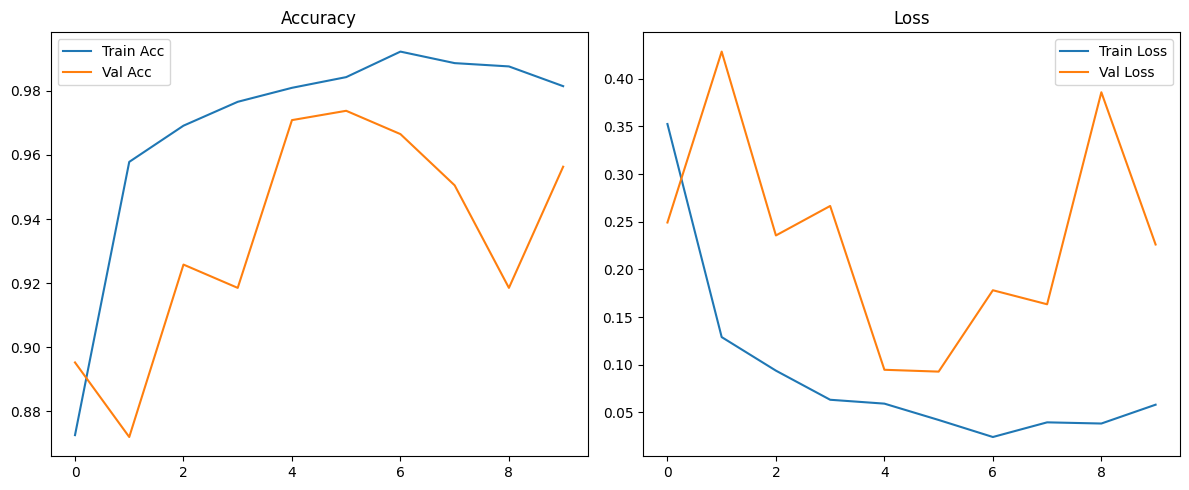

36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 215ms/step - accuracy: 0.9755 - loss: 0.0851
✅ Test Accuracy: 0.9694
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step

Classification Report:
               precision    recall  f1-score   support

      glioma       0.97      1.00      0.99       264
  meningioma       0.97      0.90      0.93       268
     notumor       0.97      0.99      0.98       319
   pituitary       0.96      0.99      0.98       294

    accuracy                           0.97      1145
   macro avg       0.97      0.97      0.97      1145
weighted avg       0.97      0.97      0.97      1145



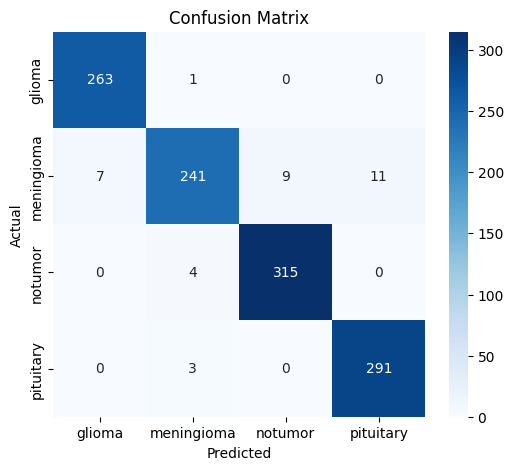

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# ⚙️ Parameters
DATASET_PATH = "/kaggle/input/harvard-medical-dataset/Harvard_medical_dataset/Training"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10  # Increase for better performance
NUM_CLASSES = 4

# 🧠 Step 1: Load image paths and labels
image_paths, labels = [], []
class_dirs = sorted([d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))])
for class_dir in class_dirs:
    class_path = os.path.join(DATASET_PATH, class_dir)
    for fname in os.listdir(class_path):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(class_path, fname))
            labels.append(class_dir)

df = pd.DataFrame({'filename': image_paths, 'class': labels})
print(f"✅ Total images found: {len(df)}")
print("🧾 Class distribution:\n", df['class'].value_counts())

# 🧪 Step 2: Split dataset
train_df, test_df = train_test_split(df, stratify=df['class'], test_size=0.20, random_state=42)
train_df, val_df = train_test_split(train_df, stratify=train_df['class'], test_size=0.15, random_state=42)

# 🔄 Step 3: Data generators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_dataframe(train_df, x_col='filename', y_col='class',
                                              target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                              class_mode='categorical')
val_gen = valid_datagen.flow_from_dataframe(val_df, x_col='filename', y_col='class',
                                            target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                            class_mode='categorical')
test_gen = test_datagen.flow_from_dataframe(test_df, x_col='filename', y_col='class',
                                            target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                            class_mode='categorical', shuffle=False)

# 🔧 Step 4: Build model using ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
preds = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=preds)

# ⚙️ Step 5: Compile model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 📦 Step 6: Callbacks
checkpoint = ModelCheckpoint('resnet50_best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 🏋️ Step 7: Train model
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=EPOCHS,
                    callbacks=[checkpoint, earlystop])

# 📈 Step 8: Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# 🧪 Step 9: Evaluate on test set
loss, acc = model.evaluate(test_gen)
print(f"✅ Test Accuracy: {acc:.4f}")

# 🧾 Step 10: Classification report and confusion matrix
y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen), axis=1)
class_labels = list(test_gen.class_indices.keys())

print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()